<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>What is Colaboratory?</h1>

Colaboratory, or "Colab" for short, allows you to write and execute Python in your browser, with 
- Zero configuration required
- Free access to GPUs
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more, or just get started below!

## **Getting started**

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [1]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [2]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

## Data science

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

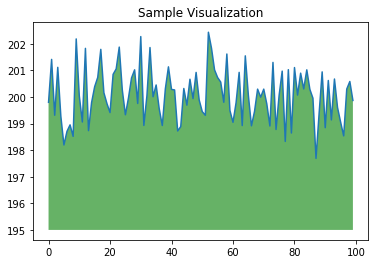

In [3]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

## Machine learning

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb). Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

## More Resources

### Working with Notebooks in Colab
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [TensorFlow 2 in Colab](/notebooks/tensorflow_version.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb)
- [Tensorflow concepts](/notebooks/mlcc/tensorflow_programming_concepts.ipynb)
- [First steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Intro to neural nets](/notebooks/mlcc/intro_to_neural_nets.ipynb)
- [Intro to sparse data and embeddings](/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb)

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colaboratory makes possible, check out these  tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import json
import tweepy as tw
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import re
from textblob import TextBlob
import networkx
import networkx as nx
import earthpy as et

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# Get the already collected twitter data in JSON format
et.data.get_data('twitter-flood')

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
flood_tweets_path = os.path.join("twitter-flood", "boulder_flood_geolocated_tweets.json")
flood_tweets_path

'twitter-flood/boulder_flood_geolocated_tweets.json'

In [6]:
# Loop through each tweet in the JSON file and append it to a list
flood_tweets = []
for line in open(flood_tweets_path, 'r'):
    flood_tweets.append(json.loads(line))

# View a single tweet in your list.
flood_tweets[1]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Dec 31 18:49:31 +0000 2013',
 'entities': {'hashtags': [{'indices': [108, 113], 'text': 'snow'},
   {'indices': [114, 119], 'text': 'COwx'},
   {'indices': [120, 128], 'text': 'weather'},
   {'indices': [129, 136], 'text': 'Denver'}],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 1214463582,
    'id_str': '1214463582',
    'indices': [0, 14],
    'name': 'WeatherDude',
    'screen_name': 'WeatherDude17'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 418091565161017345,
 'id_str': '418091565161017345',
 'in_reply_to_screen_name': 'WeatherDude17',
 'in_reply_to_status_id': 418091408994471937,
 'in_reply_to_status_id_str': '418091408994471937',
 'in_reply_to_user_id': 1214463582,
 'in_reply_to_user_id_str': '1214463582',
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="no

In [7]:
type(flood_tweets[1])

dict

In [8]:
a_single_tweet = flood_tweets[1]
a_single_tweet.keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

In [9]:
# View the created at time stamp in the dictionary
a_single_tweet["created_at"]

'Tue Dec 31 18:49:31 +0000 2013'

In [10]:
a_single_tweet["entities"]["hashtags"]

[{'indices': [108, 113], 'text': 'snow'},
 {'indices': [114, 119], 'text': 'COwx'},
 {'indices': [120, 128], 'text': 'weather'},
 {'indices': [129, 136], 'text': 'Denver'}]

In [11]:
# Get the second item in the list and it's associated hashtag
a_single_tweet["entities"]["hashtags"][1]["text"]

'COwx'

In [12]:
def remove_url_punctuation(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)
    
    punct_pattern = re.compile(r'[^\w\s]')
    no_punct = punct_pattern.sub(r'', no_url)
    
    # Clean up punctuation (including pound signs)
    return no_punct

In [13]:
# Create a custom search term and define the number of tweets
flood_tweets[2]["text"]

'Story of my life! 😂 #boulder http://t.co/ZMfNKEl0xD'

In [14]:
# Remove URLs
tweets_no_urls = [remove_url_punctuation(atweet["text"]) for atweet in flood_tweets]
tweets_no_urls[2]

'Story of my life  boulder '

In [15]:
# Create a list of lists containing lowercase words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]
words_in_tweet[2]

['story', 'of', 'my', 'life', 'boulder']

In [16]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Count each word across all tweets - notice there are still stop words
counts_no_urls = collections.Counter(all_words_no_urls)
counts_no_urls.most_common(15)

[('rt', 7884),
 ('boulder', 6980),
 ('the', 6849),
 ('in', 5730),
 ('to', 5619),
 ('cowx', 5338),
 ('boulderflood', 5317),
 ('of', 4778),
 ('coflood', 4312),
 ('a', 3240),
 ('for', 3156),
 ('and', 2823),
 ('is', 2596),
 ('at', 2330),
 ('on', 2282)]

In [17]:
# Remove stop words and any other words you want to clean up
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection and other twitter related words (rt = retweet on twitter)
collection_words = ['rt']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

tweets_nsw_nc[2]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['story', 'life', 'boulder']

In [18]:
# Process for word counts
all_words_nsw = list(itertools.chain(*tweets_nsw_nc))

counts_nsw = collections.Counter(all_words_nsw)

clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])
clean_tweets_nsw

,words,count
0,boulder,6980
1,cowx,5338
2,boulderflood,5317
3,coflood,4312
4,colorado,2237
5,denver,1480
6,flood,1285
7,snow,1202
8,amp,1202
9,weather,1070


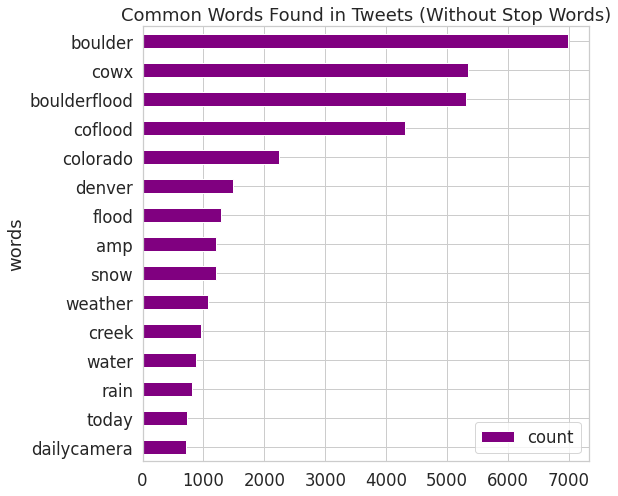

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

In [20]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# Flatten list of bigrams in clean tweets
coupled_words = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(coupled_words)

bigram_counts.most_common(20)

[(('cowx', 'weather'), 618),
 (('boulder', 'colorado'), 457),
 (('boulder', 'creek'), 436),
 (('cowx', 'coflood'), 408),
 (('boulderflood', 'cowx'), 287),
 (('boulder', 'county'), 268),
 (('boulderflood', 'coflood'), 256),
 (('cowx', 'gjco'), 214),
 (('boulder', 'boulderflood'), 199),
 (('cowx', 'westernslope'), 192),
 (('cowx', 'denver'), 189),
 (('flash', 'flood'), 188),
 (('boulder', 'canyon'), 185),
 (('coflood', 'cowx'), 181),
 (('wall', 'water'), 179),
 (('coflood', 'boulderflood'), 164),
 (('higher', 'ground'), 163),
 (('dailycamera', 'boulder'), 156),
 (('flood', 'warning'), 149),
 (('boulder', 'co'), 144)]

In [21]:
# Create a network plot of grouped terms
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


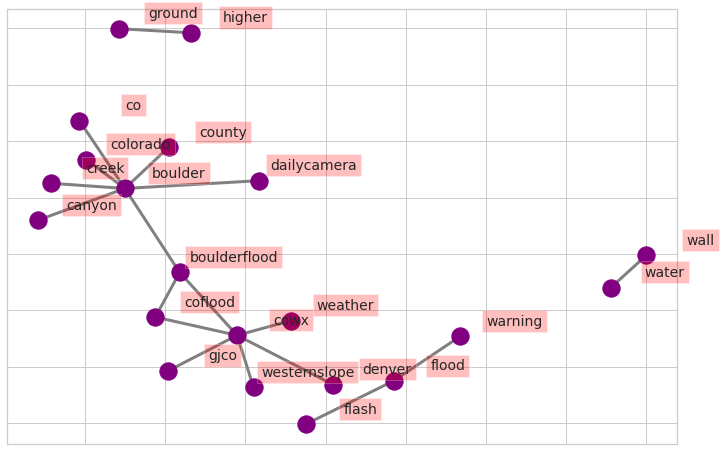

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(G, k=5.5)
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.05
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=14)
    
plt.show()

In [23]:
# Create textblob objects of the tweets
sentiment_objects = [TextBlob(tweet) for tweet in tweets_no_urls]

sentiment_objects[0].polarity, sentiment_objects[2]

(-0.5, TextBlob("Story of my life  boulder "))

In [24]:
# Create list of polarity values and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_values[2:8]

[[0.0, 'Story of my life  boulder '],
 [0.0,
  'Were looking for the two who came to help a cyclist after a hitandrun at 30thBaseline 11pm Dec 23rd Boulder CO '],
 [0.3575757575757576,
  'Happy New Year Boulder  What are some of your New Years resolutions this year'],
 [0.34545454545454546,
  'simon_Says_so Nearly 60 degrees in Boulder today Great place to live '],
 [0.0, 'Deer boulder onlyinboulder '],
 [0.0,
  'NWS has only bumped up tomrorows odds for snow in Denver from 30 to 40 To me it feels like it should be closer to 60 COwx weather']]

In [25]:
# Create dataframe containing the polarity value and tweet text
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.tail()

,polarity,tweet
18816,0.000,RT EricRobertson A more representative flood p...
18817,0.125,Warning Flash flood of boulder creek is immine...
18818,0.550,I just got an Emergency Alert Nice to know the...
18819,0.000,RT dailycamera RT CUBoulderPolice Some floodi...
18820,0.000,monikarun courtneyo eatplaylove Greeblemonkey ...


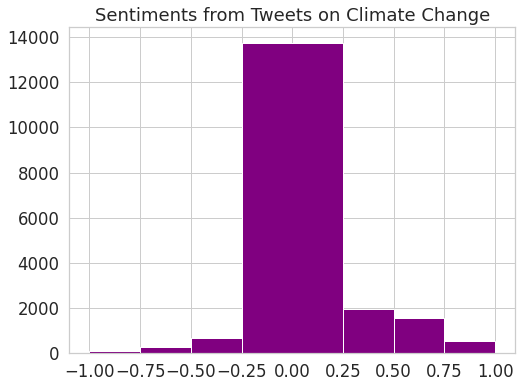

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Climate Change")
plt.show()

In [27]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]

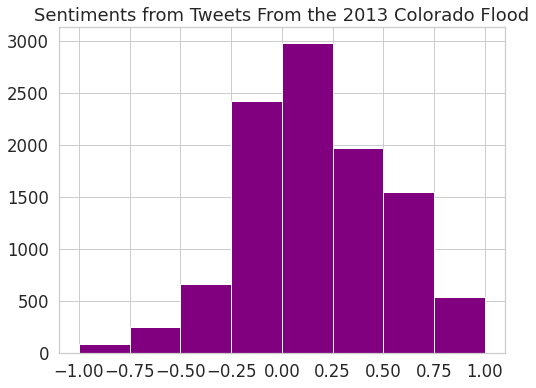

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets From the 2013 Colorado Flood")
plt.show()